## Problem 1(a): Credit Card Fraud Detection (Assignment)

Dataset: <https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud>

**Goal**: Apply anomaly detection to detect fraudulent credit card transactions and analyze contamination effects.


# Fill before submitting

- **Student:** `Zach Hatzenbeller`
- **Course:** `Data Science Modeling & Analytics`
- **Homework:** `HW #1`
- **Date:** `2025-09-14`
- **Instructor:** `Ben Rodriguez, PhD`

---

## What to Submit in your `.ipynb`

Your notebook must include, in this order:

1. **Cover Block** — Name, course, HW #, date.
2. **README (Execution & Setup)** — Python version; required packages + install steps; dataset source + download/use instructions; end‑to‑end run steps; any hardware notes (GPU/CPU).
3. **Adjustable Inputs** — A single, clearly marked code cell where we can change paths, seeds, and key hyperparameters.
4. **Problem Sections** — Each problem and sub‑part clearly labeled (e.g., “Problem 1 (a)”).
5. **Results, Summary & Conclusions** — Your takeaways, trade‑offs, limitations.
6. **References & Attributions** — Cite datasets, code you reused, articles, and **any AI tools** used (and how).

> **One file only**. The notebook must run **top‑to‑bottom** with no errors.

---

## How You’re Graded (what “full credit” looks like)

**1) Completeness & Problem Coverage (20%)**

<div style="margin-left: 40px"> To earn full points, students must ensure that all parts of the assignment, including sub-questions, are fully answered. Both qualitative and quantitative components should be addressed where required, and any coding tasks must be implemented completely without omissions. </div>

**2) Writing Quality, Technical Accuracy & Justification (20%)**

<div style="margin-left: 40px"> Writing should be clear, concise, and demonstrate graduate-level quality. All technical content must be correct, and reasoning should be sound and well-supported. Students are expected to justify their design choices and conclusions with logical arguments that reflect a strong understanding of the material. </div>

**3) Quantitative Work (0% on this HW)**

<div style="margin-left: 40px"> Assignments should clearly state all assumptions before attempting solutions. Derivations and calculations must be shown step by step, either in Markdown cells or through annotated code. Final results should be presented with appropriate units and precision, ensuring they are easy to interpret and technically correct. </div>
 
**4) Code Quality, Documentation & Execution (30%)**  
<div style="margin-left: 40px"> Code must run from top to bottom without errors, avoiding “Traceback” or other runtime issues. Programs should follow best practices for naming, formatting, and organization, with descriptive variables and functions. Meaningful comments should be included to explain key logic, making the code both efficient and easy to follow. </div>

**5) Examples, Test Cases & Visuals (20%)**

<div style="margin-left: 40px"> Students should include realistic examples and test cases that demonstrate program functionality, with outputs clearly labeled. Figures and tables must be properly titled, captioned, and have labeled axes. For machine learning tasks, particularly those with imbalanced datasets such as Credit Card Fraud or NSL-KDD, evaluation metrics must go beyond simple accuracy and include measures like precision, recall, F1-score, and ROC or PR curves. </div>

**6) Notebook README & Reproducibility (10%)**

<div style="margin-left: 40px"> Each notebook must include a README section containing the Python version, a list of required packages with installation instructions, dataset details with download information, and complete steps to run the notebook. The work should be fully reproducible on another system, with seeds set for consistency and relative paths used instead of system-dependent absolute paths. </div>

---

## README (Execution & Setup)

**Use this section to make your notebook reproducible.**

- **Python version:** `3.11.1`
- **Required packages:** `numpy`, `pandas`, `scikit-learn`, `matplotlib`, `kagglehub`
- **Install instructions (if non-standard):**
  ```bash
  pip install numpy pandas scikit-learn matplotlib kagglehub
  ```
- **Datasets used:**
  - `creditcard.csv` was downloaded straight from kagglehub
  - All steps are in order and will clean/transform the dataset if necessary
- **How to run this notebook:**
  1. Run all cells in order (Kernel → Restart & Run All).
  2. Verify that all outputs match those in the **Sample Tests** section.
  3. Ensure figures and tables render correctly.

**README hint**: Place `creditcard.csv` in `./data/` (or set `DATA_PATH` below). The dataset can be downloaded from Kaggle. Due to size limits, keep only relative paths in this notebook.


In [1]:
# Environment Check (Example)
import sys
import platform

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
try:
    import numpy as np
    import pandas as pd

    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
except Exception as e:
    print("Optional packages missing or version check failed:", e)

Python: 3.11.1
Platform: Windows-10-10.0.26100-SP0
NumPy: 1.26.4
Pandas: 2.2.0


## Problem Statement for 1(a): Credit Card Fraud Detection

Using the **Credit Card Fraud Detection** dataset (highly imbalanced; anonymized features `V1..V28`, `Time`, `Amount`, and binary label `Class`), complete the following:

1. **Isolation Forest**: Implement an anomaly detection model using Isolation Forest on the transaction data. **Report the percentage of transactions flagged as potentially fraudulent** (i.e., predicted anomalies) and compare with the true fraud rate.
2. **Method Comparison**: **Evaluate Isolation Forest vs. Local Outlier Factor (LOF)** on the same data. Which detects anomalies more accurately under comparable settings? Report metrics (precision, recall, F1, ROC-AUC/PR-AUC) and discuss trade-offs.
3. **Contamination Sensitivity**: **Vary the `contamination` parameter** in your anomaly detector(s). What difficulties arise when tuning it? How does it influence thresholding, class balance, and evaluation metrics? Include a short parameter sweep and analysis.


In [2]:
# Adjustable Inputs — edit as needed
import os, random, numpy as np
from pathlib import Path

# If not installed: pip install kagglehub
import kagglehub

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Prefer explicit override; otherwise download from Kaggle ---
env_path = os.getenv("DATA_PATH", "").strip()

if env_path and Path(env_path).exists():
    DATA_PATH = env_path
    download_dir = Path(env_path).parent
else:
    # Download latest version of the dataset
    download_dir = Path(kagglehub.dataset_download("mlg-ulb/creditcardfraud"))

    # Try to find the canonical CSV
    target_names = {"creditcard.csv"}
    csv_path = None

    # 1) Exact match (case-insensitive)
    for p in download_dir.rglob("*.csv"):
        if p.name.lower() in {n.lower() for n in target_names}:
            csv_path = p
            break

    # 2) Fallback: first CSV in the folder
    if csv_path is None:
        csvs = list(download_dir.rglob("*.csv"))
        if not csvs:
            raise FileNotFoundError(
                f"No CSV found in {download_dir}. "
                f"Files: {[str(p.relative_to(download_dir)) for p in download_dir.rglob('*')]}"
            )
        csv_path = csvs[0]

    DATA_PATH = str(csv_path)

print("Kaggle dataset directory:", str(download_dir))
print("Resolved CSV path:", DATA_PATH)

TEST_SIZE = 0.2
N_JOBS = -1  # for parallelizable steps where applicable

# Isolation Forest / LOF defaults
IF_N_ESTIMATORS = 200
IF_MAX_SAMPLES = "auto"
USE_SCALING = True
IF_CONTAMINATION = 0.001  # try values like 0.0005, 0.001, 0.005, 0.01
LOF_N_NEIGHBORS = 20
LOF_CONTAMINATION = IF_CONTAMINATION
CONTAMINATION_GRID = [
    0.0005,
    0.001,
    0.002,
    0.005,
]  # used in Contamination sweep for Isolation Forest

print(f"SEED={SEED}, TEST_SIZE={TEST_SIZE}")


Kaggle dataset directory: C:\Users\zhatz\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
Resolved CSV path: C:\Users\zhatz\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3\creditcard.csv
SEED=42, TEST_SIZE=0.2


In [3]:
# Data Loading
import pandas as pd

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. Please download 'creditcard.csv' "
        "from Kaggle and place it under ./data/ or set DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Quick EDA: class balance & basic stats
import pandas as pd

# TODO: Show class balance and basic stats (no seaborn).
print(df["Class"].value_counts(normalize=True).rename("ratio"))
display(df.describe())


Class
0    0.998273
1    0.001727
Name: ratio, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
# Feature/label split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# TODO: Split X/y and standardize features (fit on train, transform train/test).
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)
scaler = StandardScaler() if USE_SCALING else None
if scaler:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled, X_test_scaled = X_train.values, X_test.values


In [6]:
# Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

# TODO: Implement Isolation Forest training, scoring, and metrics.
# Suggestion: create a function that returns a dict of metrics.
# Example signature (you may change it):
def run_isolation_forest(X_train_scaled, X_test_scaled, y_test, contamination, seed):
    """Return dict with keys: precision, recall, f1, PR-AUC, ROC-AUC, % Flagged."""

    iso_forest = IsolationForest(
        n_estimators=IF_N_ESTIMATORS,
        max_samples=IF_MAX_SAMPLES,
        contamination=contamination,
        random_state=seed,
    )

    model = iso_forest.fit(X_train_scaled)  # no y_train needed (unsupervised)

    # Predictions: map -1 (outlier) -> 1 (fraud) | 1 (inlier) -> 0 (normal)
    preds = model.predict(X_test_scaled)
    preds = np.where(preds == -1, 1, 0)

    # Scores for AUCs (flip sign so higher = more anomalous)
    scores = -model.decision_function(X_test_scaled)

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, scores)
    pr_auc = average_precision_score(y_test, scores)
    pct_flagged = preds.mean() * 100

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "% Flagged": pct_flagged,
    }
    return metrics


In [7]:
# Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor

# TODO: Implement LOF scoring and metrics.
# Consider novelty detection or standard unsupervised LOF; document your choice.
# Example signature:
def run_lof(X_train_scaled, X_test_scaled, y_test, n_neighbors, contamination):
    """Return dict with keys: precision, recall, f1, PR-AUC, ROC-AUC, % Flagged."""

    lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=True
    )

    model = lof.fit(X_train_scaled)  # no y_train needed (unsupervised)

    # Predictions: map -1 (outlier) -> 1 (fraud) | 1 (inlier) -> 0 (normal)
    preds = model.predict(X_test_scaled)
    preds = np.where(preds == -1, 1, 0)

    # Scores for AUCs (flip sign so higher = more anomalous)
    scores = -model.decision_function(X_test_scaled)

    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, scores)
    pr_auc = average_precision_score(y_test, scores)
    pct_flagged = preds.mean() * 100

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "% Flagged": pct_flagged,
    }
    return metrics


In [8]:
# Tabular comparison of IF vs LOF on test set
metrics_iso = run_isolation_forest(
    X_train_scaled, X_test_scaled, y_test, IF_CONTAMINATION, SEED
)
metrics_lof = run_lof(
    X_train_scaled, X_test_scaled, y_test, LOF_N_NEIGHBORS, LOF_CONTAMINATION
)
combined_data = {
    key: [metrics_iso[key], metrics_lof[key]] for key in metrics_iso
}
metrics_df = pd.DataFrame.from_dict(combined_data, orient='index', columns=["IF", "LOF"])
metrics_df

,IF,LOF
precision,0.366667,0.000000
recall,0.224490,0.000000
f1,0.278481,0.000000
ROC-AUC,0.953929,0.491630
PR-AUC,0.171717,0.002494
% Flagged,0.105333,0.101822


In [9]:
# Contamination sweep for Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    roc_auc_score,
)
import numpy as np, pandas as pd

records = []
for c in CONTAMINATION_GRID:
    # TODO: Fit IsolationForest with contamination=c on X_train_scaled, score/predict on X_test_scaled,
    # compute precision, recall, f1, PR-AUC, ROC-AUC, and % flagged.
    # Append a dict with keys: 'contamination','precision','recall','f1','PR-AUC','ROC-AUC','% Flagged' to records.
    metrics_iso = run_isolation_forest(
        X_train_scaled, X_test_scaled, y_test, c, SEED
    )
    metrics_iso["contamination"] = c
    records.append(metrics_iso)

sweep_df = pd.DataFrame(records)
display(sweep_df)


,precision,recall,f1,ROC-AUC,PR-AUC,% Flagged,contamination
0,0.352941,0.122449,0.181818,0.953929,0.171717,0.059689,0.0005
1,0.366667,0.224490,0.278481,0.953929,0.171717,0.105333,0.0010
2,0.271186,0.326531,0.296296,0.953929,0.171717,0.207156,0.0020
3,0.150327,0.469388,0.227723,0.953929,0.171717,0.537200,0.0050


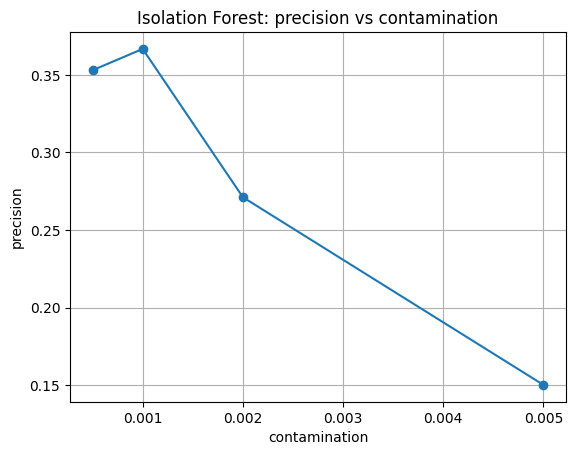

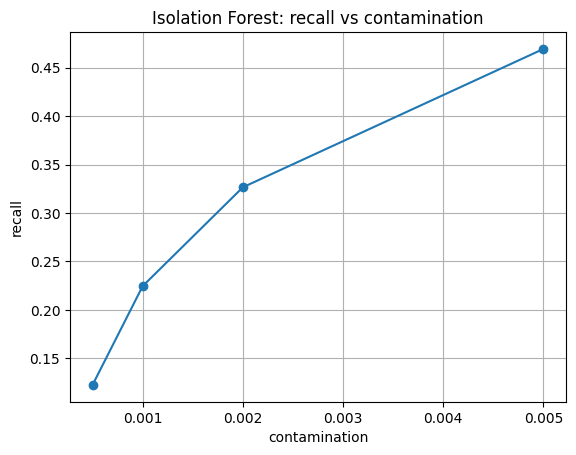

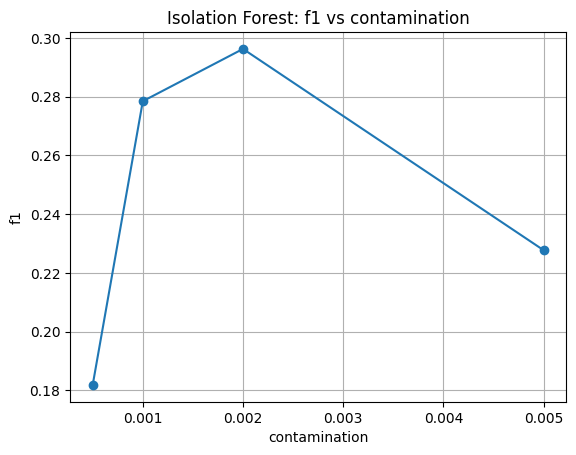

In [10]:
# Plot effect of contamination on metrics
import matplotlib.pyplot as plt

# TODO: Plot selected metrics vs contamination from sweep_df.
for metric in ["precision", "recall", "f1"]:
    plt.figure()
    plt.plot(sweep_df["contamination"], sweep_df[metric], marker="o")
    plt.title(f"Isolation Forest: {metric} vs contamination")
    plt.xlabel("contamination")
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()


## Analysis: Contamination Effects

- **Thresholding**: The `contamination` parameter sets an expected fraction of anomalies and directly influences decision thresholds. Lower values typically reduce false positives but risk missing true frauds (lower recall). Higher values catch more anomalies but can inflate false positives and reduce precision.
- **Imbalanced Data**: With highly imbalanced labels, small changes in `contamination` can cause large swings in metrics. This makes tuning difficult without a validation protocol or domain prior.
- **Metric Sensitivity**: Prefer **PR-AUC** over ROC-AUC in severe class imbalance. Discuss how operational thresholds (e.g., human review capacity) align with chosen `contamination`.
    - PR-AUC tells you how well the model balances precision and recall across all thresholds.
    - But in practice, you pick a specific operating point (threshold or contamination) that matches your capacity.
    - If you can only review 5,000 transactions/day, you’d tune the contamination/threshold so that ~5,000 cases are flagged, then monitor precision/recall at that setting.
- **Operational Costs**: Explain the trade-offs between investigating flagged transactions (cost) and missing fraud (risk). Tie your recommended `contamination` to these constraints.
    - `contamination` should not be chosen purely from model performance metrics, it must be tied to the intersection of fraud loss risk and investigation cost capacity. The sweet spot is the setting where every extra case flagged still provides more fraud savings than it costs to review.


## Results Summary

- **% anomalies flagged (IF)**: 0.105333
- **Comparison (IF vs LOF)**: Isolation forest performed better overall by a wide margin. IF had better precision, recall and f1 scores as well as a better PR-AUC making it the clear winner.
- **Best `contamination` (reasoned)**: Best `contamination` was 0.0010 due to this value having the highest precision, a good recall and high f1 score. PR-AUC scores stayed the same across all `contamination` values so the decision maker was the precision score since it is highly valuable to increase precision with such an imbalanced dataset


## Conclusions

In highly imbalanced fraud detection settings, I learned that metrics like **PR-AUC** are more informative than ROC-AUC, since they directly capture the trade-off between catching rare frauds and limiting false alarms. The `contamination` parameter shapes results by controlling how many cases are flagged, which must align with operational capacity for human review to balance the cost of investigations against the risk of missed fraud. **Isolation Forest** is often preferred for scalability and its ability to generalize to unseen data, while **LOF** can capture local density anomalies but is more sensitive to neighborhood size and less scalable. Limitations include reliance on unsupervised assumptions, sensitivity to feature distributions, and difficulty in setting optimal thresholds. Next steps include improving **feature engineering**, exploring **score calibration** and **threshold tuning**, and eventually incorporating **supervised models** when reliable fraud labels are available to better optimize precision–recall trade-offs.



## References

- Kaggle Dataset: Credit Card Fraud Detection — <https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud>
- Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest.
- Breunig, M. M., Kriegel, H.-P., Ng, R. T., & Sander, J. (2000). LOF: Identifying Density-Based Local Outliers.
